<a href="https://colab.research.google.com/github/dcpatton/NLP/blob/master/Friends_Albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import random

print(tf.__version__)

seed = 51

tf.random.set_seed(seed)
random.seed(seed)

2.3.0


# Load and prep data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving friends_test.json to friends_test.json
Saving friends_dev.json to friends_dev.json
Saving friends_train.json to friends_train.json


# Albert

In [3]:
!pip install sentencepiece -q

     |████████████████████████████████| 1.1MB 4.5MB/s 


In [4]:
!wget -nv https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

2020-08-04 23:40:55 URL:https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py [16775/16775] -> "tokenization.py" [1]


In [5]:
from numpy import array

def albert_encode(texts):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
      text = tokenizer.tokenize(text)
      text = text[:max_seq_length-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      input_sequence = text
      pad_len = max_seq_length - len(input_sequence)
      tokens = tokenizer.convert_tokens_to_ids(input_sequence)
      tokens += [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_seq_length
      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)

    return [array(all_tokens), array(all_masks), array(all_segments)]

In [6]:
def prep_data(df):
    
    texts = []
    labels = []

    for _,row in df.iterrows():
      texts.append(row.utterance)
      labels.append(row.label)

    return albert_encode(texts), array(labels)

# Competition prediction task



> In the competition they only predict samples with joy, sadness, anger, and neutral. All others are discarded. 



In [7]:
import pandas as pd

allowed_emotions = ['joy', 'sadness', 'anger', 'neutral']

df = pd.read_json('friends_train.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

train_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 

df = pd.read_json('friends_dev.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

val_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])

df = pd.read_json('friends_test.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

test_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])
test_df['emotion'].value_counts()

neutral    1287
joy         304
anger       161
sadness      85
Name: emotion, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
# lets combine + shuffle train and val and then split again.
combined_df = pd.concat([train_df, val_df])
train_df, val_df = train_test_split(combined_df, test_size=0.2, shuffle=True, 
                                    stratify=combined_df['emotion'], random_state=seed)

In [9]:
max_len = -1
for _,row in combined_df.iterrows():
  length = len(row.utterance)
  if length > max_len:
    max_len = length

max_len

256

In [10]:
# create the labels as integers
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['emotion'].values)
train_df.drop(['emotion'], axis='columns', inplace=True)

val_df['label'] = labelEncoder.transform(val_df['emotion'].values)
val_df.drop(['emotion'], axis='columns', inplace=True)

test_df['label'] = labelEncoder.transform(test_df['emotion'].values)
test_df.drop(['emotion'], axis='columns', inplace=True)

num_classes=len(labelEncoder.classes_)
labelEncoder.classes_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

array(['anger', 'joy', 'neutral', 'sadness'], dtype=object)

In [11]:
# max_seq_length = 128
max_seq_length = max_len
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
albert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/1",
                              trainable=False)
pooled_output, sequence_output = albert_layer([input_word_ids, input_mask, segment_ids])

In [12]:
import tokenization
import sentencepiece

In [13]:
sp_model_file = albert_layer.resolved_object.sp_model_file.asset_path.numpy()
tokenizer = tokenization.FullSentencePieceTokenizer(sp_model_file)

In [14]:
x_train, y_train = prep_data(train_df)
x_val, y_val = prep_data(val_df)
x_test, y_test = prep_data(test_df)

y_true = y_test

y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [15]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

m = Dense(32, activation='relu')(pooled_output)
out = Dense(num_classes, activation='softmax')(m)
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[out])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [16]:
!pip install focal-loss -q

In [17]:
import tensorflow_addons as tfa
# radam = tfa.optimizers.RectifiedAdam()
radam = tfa.optimizers.RectifiedAdam(
    lr=1e-3,
    # total_steps=10000,
    total_steps=100,
    warmup_proportion=0.1,
    min_lr=1e-5,
)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

from focal_loss import SparseCategoricalFocalLoss
# loss_func = SparseCategoricalFocalLoss(gamma=2)
loss_func = SparseCategoricalFocalLoss(gamma=[9, 8, 3, 9], from_logits=True)

total = 161+304+1287+85
weight_for_0 = (1 / 161)*(total)/4.0 
weight_for_1 = (1 / 304)*(total)/4.0
weight_for_2 = (1 / 1287)*(total)/4.0
weight_for_3 = (1 / 85)*(total)/4.0
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

In [18]:
f1_score = tfa.metrics.F1Score(num_classes, average='micro', name='f1')

# model.compile(optimizer='adam', loss='categorical_crossentropy', 
              # metrics=[f1_score])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics=[f1_score])
# model.compile(optimizer=radam, loss='sparse_categorical_crossentropy', 
              # metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')])

In [19]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    print('Using learning_rate = ' + str(self.model.optimizer.learning_rate.numpy()))

In [20]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint( filepath, monitor='val_loss', verbose=0, 
                                        save_best_only=True, save_weights_only=True, 
                                        mode='auto')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, 
                                      verbose=1, mode='auto', restore_best_weights=False)

history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    # class_weight = class_weight
                    )

Epoch 1/100
192/192 [==============================] - 76s 396ms/step - loss: 0.1736 - f1: 0.6687 - val_loss: 0.1613 - val_f1: 0.6926
Epoch 2/100
192/192 [==============================] - 75s 393ms/step - loss: 0.1579 - f1: 0.6963 - val_loss: 0.1579 - val_f1: 0.7030
Epoch 3/100
192/192 [==============================] - 75s 393ms/step - loss: 0.1549 - f1: 0.7002 - val_loss: 0.1556 - val_f1: 0.7095
Epoch 4/100
192/192 [==============================] - 75s 393ms/step - loss: 0.1522 - f1: 0.7040 - val_loss: 0.1553 - val_f1: 0.7063
Epoch 5/100
192/192 [==============================] - 75s 393ms/step - loss: 0.1502 - f1: 0.7038 - val_loss: 0.1549 - val_f1: 0.7121
Epoch 6/100
192/192 [==============================] - 75s 393ms/step - loss: 0.1497 - f1: 0.7061 - val_loss: 0.1567 - val_f1: 0.7095
Epoch 7/100
192/192 [==============================] - 75s 393ms/step - loss: 0.1467 - f1: 0.7130 - val_loss: 0.1542 - val_f1: 0.7050
Epoch 8/100
192/192 [==============================] - 75s 393

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


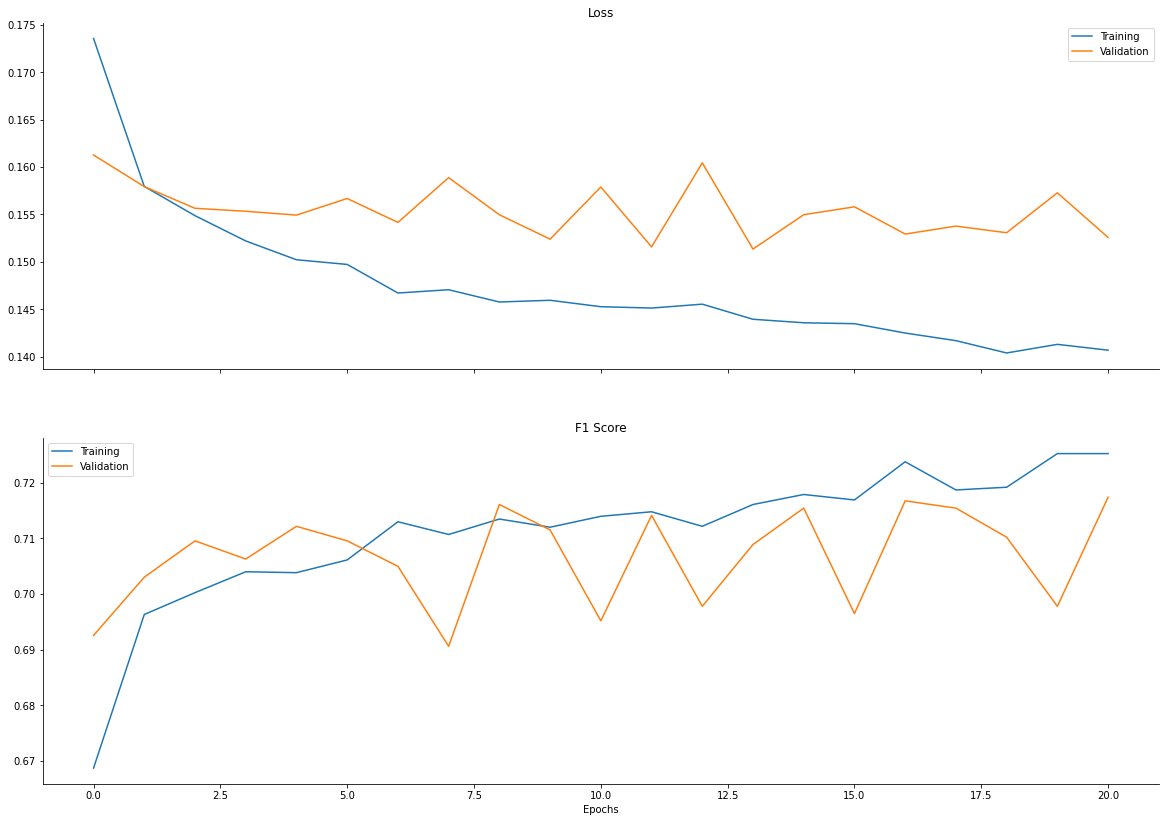

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [22]:
model.load_weights(filepath)
model.get_layer(name='keras_layer').trainable = True
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics=[f1_score])

In [24]:
history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    # class_weight = class_weight
                    )

Epoch 1/100
192/192 [==============================] - 193s 1s/step - loss: 0.1547 - f1: 0.7072 - val_loss: 0.1491 - val_f1: 0.7350
Epoch 2/100
192/192 [==============================] - 193s 1s/step - loss: 0.1447 - f1: 0.7347 - val_loss: 0.1423 - val_f1: 0.7513
Epoch 3/100
192/192 [==============================] - 193s 1s/step - loss: 0.1370 - f1: 0.7562 - val_loss: 0.1376 - val_f1: 0.7591
Epoch 4/100
192/192 [==============================] - 193s 1s/step - loss: 0.1318 - f1: 0.7637 - val_loss: 0.1342 - val_f1: 0.7624
Epoch 5/100
192/192 [==============================] - 193s 1s/step - loss: 0.1273 - f1: 0.7706 - val_loss: 0.1343 - val_f1: 0.7676
Epoch 6/100
192/192 [==============================] - 193s 1s/step - loss: 0.1237 - f1: 0.7735 - val_loss: 0.1327 - val_f1: 0.7676
Epoch 7/100
192/192 [==============================] - 193s 1s/step - loss: 0.1199 - f1: 0.7797 - val_loss: 0.1325 - val_f1: 0.7676
Epoch 8/100
192/192 [==============================] - 193s 1s/step - loss: 

KeyboardInterrupt: ignored

In [ ]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
model.load_weights(filepath)
model.evaluate(x_test, y_test, verbose=1)

* Adam, trainable=False                        : loss: 0.8156 - f1: 0.7213
* Adam, trainable=True                         : loss: 0.9203 - f1: 0.7006
* Adam with class weights, tr=False            : loss: 1.1690 - f1: 0.4970
* Adam with class weights, tr=True             : loss: 1.3971 - f1: 0.0463
* Adam with SigmoidFocalCrossEntropy, tr=False : loss: 0.1511 - f1: 0.7175
* Adam with SigmoidFocalCrossEntropy, tr=True  : loss: 0.1640 - f1: 0.7006
* RAdam with SFCE, tr=False                    : loss: 0.1480 - f1: 0.7191
* RAdam with SFCE, tr=True                     : loss: 0.1634 - f1: 0.7006
* RAdam with warmup, SFCE, tr=False            : loss: 0.1511 - f1: 0.7175
* RAdam with warmup, SFCE, tr=True             : 

* Adam with fine-tuning                        : **loss: 0.1671 - f1: 0.7654**

Go with original spits!

1D droput?

SWA?
switch to monitor val_loss

Oversampling the minority classes

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labelEncoder.classes_))